In [1]:
# import the necessary packages
import os

In [2]:
# Define the base path to the *original* input dataset and then use
# the base path to derive the image and annotations directories
ORIG_BASE_PATH = r"C:\Users\User\Documents\Table_Detection\Table_Detection_MobileNet"
ORIG_IMAGES = os.path.join(ORIG_BASE_PATH, "Images")
ORIG_ANNOTS = os.path.join(ORIG_BASE_PATH, "Annotations")

In [3]:
# Define the base path to the *new* dataset after running our dataset
# builder scripts and then use the base path to derive the paths to
# our output class label directories
BASE_PATH = r"C:\Users\User\Documents\Table_Detection\Table_dataset_MobileNet"
POSITIVE_PATH = os.path.join(BASE_PATH, "table")
NEGATIVE_PATH = os.path.join(BASE_PATH, "no_table")

In [4]:
# define the number of max proposals used when running selective
# search for (1) gathering training data and (2) performing inference
MAX_PROPOSALS = 2000
MAX_PROPOSALS_INFER = 200

In [5]:
# define the maximum number of positive and negative images to be
# generated from each image
MAX_POSITIVE = 30
MAX_NEGATIVE = 10

In [6]:
# initialize the input dimensions to the network
INPUT_DIMS = (224, 224)
# define the path to the output model and label binarizer
MODEL_PATH = "table_detector_RCNN_MobileNet.h5"
ENCODER_PATH = "label_encoder_RCNN_MobileNet.pickle"
# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.99

In [7]:
def compute_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [8]:
# import the necessary packages
#from pyimagesearch.iou import compute_iou
#from pyimagesearch import config
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

In [9]:
# loop over the output positive and negative directories
for dirPath in (POSITIVE_PATH, NEGATIVE_PATH):
	# if the output directory does not exist yet, create it
	if not os.path.exists(dirPath):
		os.makedirs(dirPath)
# grab all image paths in the input images directory
imagePaths = list(paths.list_images(ORIG_IMAGES))
# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

In [10]:
# Loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    try:
        # Show a progress report
        print("[INFO] processing image {}/{}...".format(i + 1, len(imagePaths)))

        # Extract the filename from the file path and use it to derive
        # the path to the XML annotation file
        filename = imagePath.split(os.path.sep)[-1]
        filename = filename[:filename.rfind(".")]
        annotPath = os.path.sep.join([ORIG_ANNOTS, "{}.xml".format(filename)])

        # Load the annotation file, build the soup, and initialize our
        # list of ground-truth bounding boxes
        contents = open(annotPath).read()
        soup = BeautifulSoup(contents, "html.parser")
        gtBoxes = []

        # Extract the image dimensions
        w = int(soup.find("width").string)
        h = int(soup.find("height").string)

        # Loop over all 'object' elements
        for o in soup.find_all("object"):
            # Extract the label and bounding box coordinates
            label = o.find("name").string
            xMin = int(o.find("xmin").string)
            yMin = int(o.find("ymin").string)
            xMax = int(o.find("xmax").string)
            yMax = int(o.find("ymax").string)

            # Truncate any bounding box coordinates that may fall
            # outside the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # Update our list of ground-truth bounding boxes
            gtBoxes.append((xMin, yMin, xMax, yMax))

        # Load the input image from disk
        image = cv2.imread(imagePath)
        
        if image is None:
            raise ValueError("Failed to load image: {}".format(imagePath))

        # Run selective search on the image and initialize our list of proposed boxes
        cv2.setUseOptimized(True)
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        proposedRects = []

        # Loop over the rectangles generated by selective search
        for (x, y, w, h) in rects:
            # Convert our bounding boxes from (x, y, w, h) to (startX, startY, startX, endY)
            proposedRects.append((x, y, x + w, y + h))

        # Initialize counters used to count the number of positive and negative ROIs saved thus far
        positiveROIs = 0
        negativeROIs = 0

        # Loop over the maximum number of region proposals
        for proposedRect in proposedRects[:MAX_PROPOSALS]:
            # Unpack the proposed rectangle bounding box
            (propStartX, propStartY, propEndX, propEndY) = proposedRect

            # Loop over the ground-truth bounding boxes
            for gtBox in gtBoxes:
                # Compute the intersection over union between the two boxes and unpack the ground-truth bounding box
                iou = compute_iou(gtBox, proposedRect)
                (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

                # Initialize the ROI and output path
                roi = None
                outputPath = None

                # Check to see if the IOU is greater than 70% *and* that we have not hit our positive count limit
                if iou > 0.7 and positiveROIs <= MAX_POSITIVE:
                    # Extract the ROI and then derive the output path to the positive instance
                    roi = image[propStartY:propEndY, propStartX:propEndX]
                    filename = "{}.png".format(totalPositive)
                    outputPath = os.path.sep.join([POSITIVE_PATH, filename])
                    # Increment the positive counters
                    positiveROIs += 1
                    totalPositive += 1

                # Determine if the proposed bounding box falls *within* the ground-truth bounding box
                fullOverlap = propStartX >= gtStartX
                fullOverlap = fullOverlap and propStartY >= gtStartY
                fullOverlap = fullOverlap and propEndX <= gtEndX
                fullOverlap = fullOverlap and propEndY <= gtEndY

                # Check to see if there is not full overlap *and* the IoU is less than 5% *and* we have not hit our negative count limit
                if not fullOverlap and iou < 0.05 and negativeROIs <= MAX_NEGATIVE:
                    # Extract the ROI and then derive the output path to the negative instance
                    roi = image[propStartY:propEndY, propStartX:propEndX]
                    filename = "{}.png".format(totalNegative)
                    outputPath = os.path.sep.join([NEGATIVE_PATH, filename])
                    # Increment the negative counters
                    negativeROIs += 1
                    totalNegative += 1

                # Check to see if both the ROI and output path are valid
                if roi is not None and outputPath is not None:
                    # Resize the ROI to the input dimensions of the CNN that we'll be fine-tuning, then write the ROI to disk
                    roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
                    cv2.imwrite(outputPath, roi)

        # Print the total number of positive and negative images saved
        print("Total positive images: ", totalPositive)
        print("Total negative images: ", totalNegative)

    except Exception as e:
        # Print the exception message and continue to the next image
        print("[ERROR] An error occurred for image {}: {}".format(i + 1, str(e)))
        continue

[INFO] processing image 1/505...
Total positive images:  4
Total negative images:  11
[INFO] processing image 2/505...
Total positive images:  13
Total negative images:  22
[INFO] processing image 3/505...
Total positive images:  32
Total negative images:  33
[INFO] processing image 4/505...
Total positive images:  63
Total negative images:  44
[INFO] processing image 5/505...
Total positive images:  94
Total negative images:  55
[INFO] processing image 6/505...
Total positive images:  118
Total negative images:  66
[INFO] processing image 7/505...
Total positive images:  137
Total negative images:  77
[INFO] processing image 8/505...
Total positive images:  168
Total negative images:  88
[INFO] processing image 9/505...
Total positive images:  199
Total negative images:  99
[INFO] processing image 10/505...
Total positive images:  230
Total negative images:  110
[INFO] processing image 11/505...
Total positive images:  261
Total negative images:  121
[INFO] processing image 12/505...


Total positive images:  2497
Total negative images:  1012
[INFO] processing image 93/505...
Total positive images:  2528
Total negative images:  1023
[INFO] processing image 94/505...
Total positive images:  2559
Total negative images:  1034
[INFO] processing image 95/505...
Total positive images:  2590
Total negative images:  1045
[INFO] processing image 96/505...
Total positive images:  2621
Total negative images:  1056
[INFO] processing image 97/505...
Total positive images:  2646
Total negative images:  1067
[INFO] processing image 98/505...
Total positive images:  2677
Total negative images:  1078
[INFO] processing image 99/505...
Total positive images:  2708
Total negative images:  1089
[INFO] processing image 100/505...
Total positive images:  2739
Total negative images:  1100
[INFO] processing image 101/505...
Total positive images:  2770
Total negative images:  1111
[INFO] processing image 102/505...
Total positive images:  2801
Total negative images:  1122
[INFO] processing i

Total positive images:  4562
Total negative images:  1991
[INFO] processing image 182/505...
Total positive images:  4585
Total negative images:  2002
[INFO] processing image 183/505...
Total positive images:  4614
Total negative images:  2013
[INFO] processing image 184/505...
Total positive images:  4645
Total negative images:  2024
[INFO] processing image 185/505...
Total positive images:  4676
Total negative images:  2035
[INFO] processing image 186/505...
Total positive images:  4680
Total negative images:  2046
[INFO] processing image 187/505...
Total positive images:  4689
Total negative images:  2057
[INFO] processing image 188/505...
Total positive images:  4698
Total negative images:  2068
[INFO] processing image 189/505...
Total positive images:  4729
Total negative images:  2079
[INFO] processing image 190/505...
Total positive images:  4760
Total negative images:  2090
[INFO] processing image 191/505...
Total positive images:  4780
Total negative images:  2101
[INFO] proce

Total positive images:  6211
Total negative images:  2970
[INFO] processing image 271/505...
Total positive images:  6242
Total negative images:  2981
[INFO] processing image 272/505...
Total positive images:  6261
Total negative images:  2992
[INFO] processing image 273/505...
Total positive images:  6269
Total negative images:  3003
[INFO] processing image 274/505...
Total positive images:  6286
Total negative images:  3014
[INFO] processing image 275/505...
Total positive images:  6299
Total negative images:  3025
[INFO] processing image 276/505...
Total positive images:  6313
Total negative images:  3036
[INFO] processing image 277/505...
Total positive images:  6321
Total negative images:  3047
[INFO] processing image 278/505...
Total positive images:  6337
Total negative images:  3058
[INFO] processing image 279/505...
Total positive images:  6338
Total negative images:  3069
[INFO] processing image 280/505...
Total positive images:  6369
Total negative images:  3080
[INFO] proce

Total positive images:  7784
Total negative images:  3949
[INFO] processing image 360/505...
Total positive images:  7814
Total negative images:  3960
[INFO] processing image 361/505...
Total positive images:  7836
Total negative images:  3971
[INFO] processing image 362/505...
Total positive images:  7861
Total negative images:  3982
[INFO] processing image 363/505...
Total positive images:  7878
Total negative images:  3993
[INFO] processing image 364/505...
Total positive images:  7893
Total negative images:  4004
[INFO] processing image 365/505...
Total positive images:  7918
Total negative images:  4015
[INFO] processing image 366/505...
Total positive images:  7949
Total negative images:  4026
[INFO] processing image 367/505...
Total positive images:  7980
Total negative images:  4037
[INFO] processing image 368/505...
Total positive images:  7989
Total negative images:  4048
[INFO] processing image 369/505...
Total positive images:  8004
Total negative images:  4059
[INFO] proce

Total positive images:  9922
Total negative images:  4928
[INFO] processing image 449/505...
Total positive images:  9946
Total negative images:  4939
[INFO] processing image 450/505...
Total positive images:  9977
Total negative images:  4950
[INFO] processing image 451/505...
Total positive images:  10008
Total negative images:  4961
[INFO] processing image 452/505...
Total positive images:  10008
Total negative images:  4972
[INFO] processing image 453/505...
Total positive images:  10021
Total negative images:  4983
[INFO] processing image 454/505...
Total positive images:  10047
Total negative images:  4994
[INFO] processing image 455/505...
Total positive images:  10078
Total negative images:  5005
[INFO] processing image 456/505...
Total positive images:  10109
Total negative images:  5016
[INFO] processing image 457/505...
Total positive images:  10140
Total negative images:  5027
[INFO] processing image 458/505...
Total positive images:  10157
Total negative images:  5038
[INF

In [10]:
# import the necessary packages
#from pyimagesearch import config
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import os

In [15]:
import sys
sys.argv=['']
del sys

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
args = vars(ap.parse_args())
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=INPUT_DIMS)
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


In [13]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
179/179 [==============================] - 154s 844ms/step - loss: 0.0699 - accuracy: 0.9795 - val_loss: 0.0588 - val_accuracy: 0.9805
Epoch 2/10
179/179 [==============================] - 149s 834ms/step - loss: 0.0468 - accuracy: 0.9865 - val_loss: 0.0654 - val_accuracy: 0.9826
Epoch 3/10
179/179 [==============================] - 155s 869ms/step - loss: 0.0385 - accuracy: 0.9899 - val_loss: 0.0672 - val_accuracy: 0.9777
Epoch 4/10
179/179 [==============================] - 153s 857ms/step - loss: 0.0410 - accuracy: 0.9885 - val_loss: 0.0632 - val_accuracy: 0.9777
Epoch 5/10
179/179 [==============================] - 154s 859ms/step - loss: 0.0372 - accuracy: 0.9893 - val_loss: 0.0611 - val_accuracy: 0.9784
Epoch 6/10
179/179 [==============================] - 149s 833ms/step - loss: 0.0324 - accuracy: 0.9918 - val_loss: 0.0566 - val_accuracy: 0.9833
Epoch 7/10
179/179 [==============================] - 149s 831ms/step - lo

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
45/45 [==============================] - 26s 563ms/step
              precision    recall  f1-score   support

    no_table       0.98      0.96      0.97       442
       table       0.98      0.99      0.99       995

    accuracy                           0.98      1437
   macro avg       0.98      0.98      0.98      1437
weighted avg       0.98      0.98      0.98      1437



In [18]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


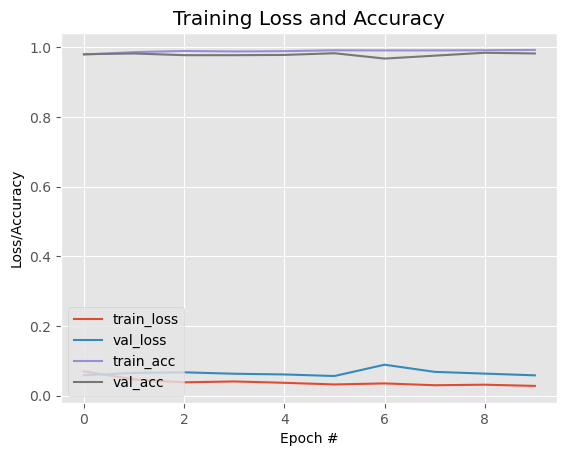

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])